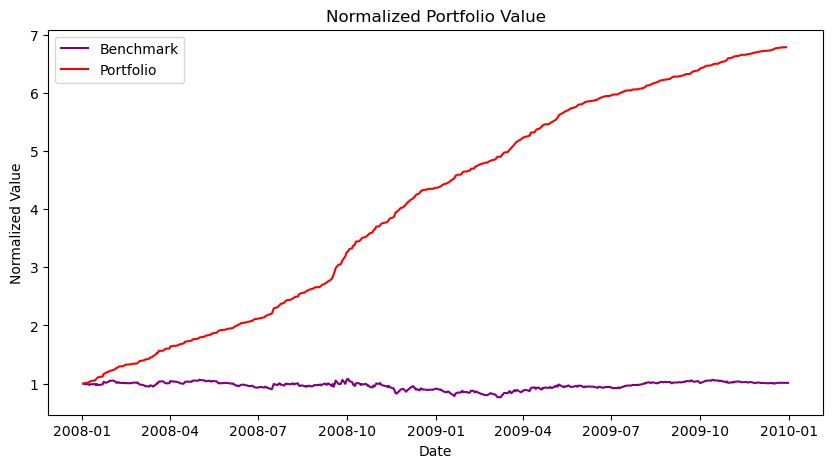

In [17]:
import matplotlib.pyplot as plt
from marketsimcode import compute_portvals,compute_daily_returns
import os
from TheoreticallyOptimalStrategy import *
from indicators import *
import datetime as dt
import pandas as pd
import numpy as np 
from util import get_data

def write_to_file(content, filename="p6_results.txt"):
    """A helper function to write content to a specific file"""
    with open(filename, "a") as text_file: # "a" option means append to file
        text_file.write(content + "\n")

def author():
    return 'ydeng335'

def evaluation_1(portvals):
    # Normalize Portfolio Values
    start_val = portvals[0]
    end_val_1 = portvals[-1]
    portvals = portvals / portvals.iloc[0]
    
    # Compute daily returns
    daily_returns = compute_daily_returns(portvals)

    # Compute Sharpe ratio
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()

    # Compute cumulative return
    cum_ret = (portvals[-1] / portvals[0]) - 1

    # Compute standard deviation of daily returns
    std_daily_ret = daily_returns.std()

    # Compute average daily return
    avg_daily_ret = daily_returns.mean()

    # Compute ending value of the portfolio
    end_val_2 = portvals[-1]

    # Prepare the output string
    output = f"Start Value: {start_val:.6f}\n" \
             f"Final Value: {end_val_1:.6f}\n" \
             f"Sharpe Ratio: {sharpe_ratio:.6f}\n" \
             f"Cumulative Return: {cum_ret:.6f}\n" \
             f"Standard Deviation of Daily Returns: {std_daily_ret:.6f}\n" \
             f"Average Daily Return: {avg_daily_ret:.6f}\n" \
             f"Ending Value Ratio of Portfolio: {end_val_2:.6f}"
    
    return output


def test_code_1(sd=dt.datetime(2008, 1, 1), ed=dt.datetime(2009,12,31), sv=100000):
    # Get price data for the given date range
    prices = get_data(['JPM'], pd.date_range(sd, ed))
    prices.fillna(method='ffill', inplace=True)
    prices.fillna(method='bfill', inplace=True)
    prices = prices['JPM']

    # Get the first available date in prices
    first_trading_day = prices.index.min()
    # Get the last available date in prices
    last_trading_day = prices.index.max()
    # Create the benchmark_orders dataframe
    benchmark_orders = pd.DataFrame(data={'Order': ['BUY'], 'Symbol': ['JPM'], 'Shares': [1000]}, index=[first_trading_day])
    benchmark_orders.index.name = 'Date'
    benchmark_orders.loc[last_trading_day] = ['BUY', 'JPM', 0]

    global optimal_orders_global
    # Get the optimal orders from the testPolicy function
    optimal_orders = testPolicy(symbol="JPM", sd=sd, ed=ed, sv=sv)
    optimal_orders = optimal_orders[optimal_orders!=0].dropna()
    optimal_orders = optimal_orders.reset_index()
    optimal_orders.columns = ['Date', 'Shares']
    optimal_orders['Symbol'] = 'JPM'
    optimal_orders['Order'] = optimal_orders['Shares'].apply(lambda x: 'BUY' if x>0 else 'SELL')
    optimal_orders['Shares'] = optimal_orders['Shares'].abs()
    optimal_orders = optimal_orders.set_index('Date')
    optimal_orders = optimal_orders[['Order', 'Symbol', 'Shares']]


    # Filter orders dataframes to only include dates where price data exists
    benchmark_orders = benchmark_orders[benchmark_orders.index.isin(prices.index)]
    optimal_orders = optimal_orders[optimal_orders.index.isin(prices.index)]

    # Compute the portfolio values for both strategies
    benchmark_portvals = compute_portvals(benchmark_orders, start_val=sv, commission=0.0, impact=0.0)
    optimal_portvals = compute_portvals(optimal_orders, start_val=sv, commission=0.0, impact=0.0)

    # Store optimal orders in the global variable instead of saving to a CSV
    optimal_orders_global = optimal_orders

    # Plot the normalized portfolio values
    plt.figure(figsize=(10,5))
    plt.plot(benchmark_portvals / benchmark_portvals.iloc[0], color='purple', label='Benchmark')
    plt.plot(optimal_portvals / optimal_portvals.iloc[0], color='red', label='Portfolio')
    plt.title('Normalized Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.savefig('images/portfolio_value.png')

    benchmark_stats = evaluation_1(benchmark_portvals)
    optimal_stats = evaluation_1(optimal_portvals)

    write_to_file("=== Benchmark Stats ===")
    write_to_file(benchmark_stats)
    write_to_file("=== Optimal Stats ===")
    write_to_file(optimal_stats)

import matplotlib.gridspec as gridspec

def test_code_2(sd='2008-1-1', ed='2009-12-31', symbol='JPM'):
    # Get stock data and add indicators
    df = get_indicators(sd, ed, symbol)

    # Read optimal strategy from the global variable 
    global optimal_orders_global
    optimal_orders = optimal_orders_global

    # Define trading points: 1 for buying, -1 for selling, and 0 for holding
    trading_points = pd.Series(0, index=df.index)
    trading_points[optimal_orders[optimal_orders['Order'] == 'BUY'].index] = -1
    trading_points[optimal_orders[optimal_orders['Order'] == 'SELL'].index] = 1
    df['Trading Points'] = trading_points

    # Add buying and selling points
    buy_signals = optimal_orders[optimal_orders['Order'] == 'BUY'].index
    sell_signals = optimal_orders[optimal_orders['Order'] == 'SELL'].index

    # Plot each indicator with normalized price and trading points
    for col in df.columns:
        if col in {symbol, 'Trading Points'}:
            continue

        # Set up a grid of plots
        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

        # Plot the indicator values over time
        ax0 = plt.subplot(gs[0])
        ax0.plot(df[symbol], label=symbol + " (Normalized Price)", color='purple')
        ax0.plot(df[col], label=col, color='blue')
        ax0.scatter(buy_signals, df.loc[buy_signals, col], color='green', marker='^', label='Buy')
        ax0.scatter(sell_signals, df.loc[sell_signals, col], color='red', marker='v', label='Sell')
        ax0.set_title(col + ' Indicator vs Normalized Price')
        ax0.set_ylabel('Normalized Value')
        ax0.legend()

        # Plot the histogram of indicator values
        ax1 = plt.subplot(gs[1])
        ax1.hist(df[col], bins=50, color='blue', alpha=0.7)
        ax1.set_title(col + ' Histogram')
        ax1.set_xlabel('Indicator Value')
        ax1.set_ylabel('Frequency')

        # Save the figure
        plt.tight_layout()
        plt.savefig('images/{}_hist_and_price.png'.format(col))
        plt.close(fig)

    # Compute correlation of each indicator with the trading points
    correlations = df.corr()['Trading Points'].drop('Trading Points')

    # Save correlations to p6_results.txt
    write_to_file("=== Correlations ===")
    write_to_file(str(correlations))


if __name__ == "__main__":
    test_code_1()
    test_code_2()